# requirements

In [ ]:
!pip install einops
!pip install timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls

In [ ]:
import sys
sys.path.append("../")
from torch.nn import LayerNorm, Linear, Dropout, Softmax
from einops import rearrange, repeat
import copy
from timm.models.layers import DropPath, trunc_normal_
from pathlib import Path
import re
import torch.backends.cudnn as cudnn
import record
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import math
from PIL import Image
import time
import torchvision.transforms.functional as TF
from torch.nn.parameter import Parameter
from sklearn.decomposition import PCA
from scipy.io import loadmat as loadmat
from scipy import io
import torch.utils.data as dataf
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import einsum
import random
import numpy as np
import os
import seaborn as sns
cudnn.deterministic = True
cudnn.benchmark = False


# MFT WITH CHANNEL TOKENIZATION

In [2]:
#MFT WITH CHANNEL TOKENIZATION

from torch.nn import LayerNorm,Linear,Dropout,Softmax
from axial_attention import AxialAttention
import copy



def INF(B,H,W):
     return -torch.diag(torch.tensor(float("inf")).cuda().repeat(H),0).unsqueeze(0).repeat(B*W,1,1)

     
class HetConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,padding = None, bias = None,p = 64, g = 64):
        super(HetConv, self).__init__()
        # Groupwise Convolution
        self.gwc = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,groups=g,padding = kernel_size//3, stride = stride)
        # Pointwise Convolution
        self.pwc = nn.Conv2d(in_channels, out_channels, kernel_size=1,groups=p, stride = stride)
    def forward(self, x):
        return self.gwc(x) + self.pwc(x)   


class Mlp(nn.Module):
    def __init__(self, dim):
        super(Mlp, self).__init__()
        self.fc1 = Linear(dim, 512)
        self.fc2 = Linear(512, dim)
        self.act_fn = nn.GELU()
        self.dropout = Dropout(0.1)

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x
class Block(nn.Module):
    def __init__(self, dim):
        super(Block, self).__init__()
        self.hidden_size = dim
        self.attention_norm = LayerNorm(dim, eps=1e-6)
        self.ffn_norm = LayerNorm(dim, eps=1e-6)
        self.ffn = Mlp(dim)
#         self.attn = Attention(dim = 64)
        self.attn = AxialAttention(
            dim = dim,                  # embedding dimension
            dim_index = -1,             # where is the embedding dimension
            heads = 8,                  # number of heads for multi-head attention
            num_dimensions = 1          # number of axial dimensions (images is 2, video is 3, or more)
        )

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x= self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        
        return x

class TransformerEncoder(nn.Module):

    def __init__(self, dim, num_heads= 8, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0.1, attn_drop=0.1,
                 drop_path=0.1, act_layer=nn.GELU, norm_layer=nn.LayerNorm, has_mlp=False):
        super().__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(dim, eps=1e-6)
        for _ in range(2):
            layer = Block(dim)
            self.layer.append(copy.deepcopy(layer))
       

    def forward(self, x):
        for layer_block in self.layer:
            x= layer_block(x)
            
        encoded = self.encoder_norm(x)
        return encoded[:,0]


class MFT(nn.Module):
    def __init__(self, FM, NC, NCLidar, Classes, HSIOnly):
        super(MFT, self).__init__()
        self.HSIOnly = HSIOnly
        self.conv5 = nn.Sequential(
            nn.Conv3d(1, 8, (9, 3, 3), padding=(0,1,1), stride = 1),
            nn.BatchNorm3d(8),
            nn.ReLU()
        )
        
        self.conv6 = nn.Sequential(
            HetConv(8 * (NC - 8), FM*4,
                p = 1,
                g = (FM*4)//4 if (8 * (NC - 8))%FM == 0 else (FM*4)//8,
                   ),
            nn.BatchNorm2d(FM*4),
            nn.ReLU()
        )
        
        self.last_BandSize = NC//2//2//2
        
        self.lidarConv = nn.Sequential(
                        nn.Conv2d(NCLidar,64,3,1,1),
                        nn.BatchNorm2d(64),
                        nn.GELU()
                        )
        self.ca = TransformerEncoder(FM*4)
        self.out3 = nn.Linear(FM*4 , Classes)
        self.position_embeddings = nn.Parameter(torch.randn(1, 4 + 1, FM*4))
        self.dropout = nn.Dropout(0.1)
        torch.nn.init.xavier_uniform_(self.out3.weight)
        torch.nn.init.normal_(self.out3.bias, std=1e-6)
        self.token_wA = nn.Parameter(torch.empty(1, 4, 64),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wA)
        self.token_wV = nn.Parameter(torch.empty(1, 64, 64),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wV)
        
        self.token_wA_L = nn.Parameter(torch.empty(1, 1, 64),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wA_L)
        self.token_wV_L = nn.Parameter(torch.empty(1, 64, 64),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wV_L)
                
        

    def forward(self, x1, x2):
        x1 = x1.reshape(x1.shape[0],-1,patchsize,patchsize)
        x1 = x1.unsqueeze(1)
        x2 = x2.reshape(x2.shape[0],-1,patchsize,patchsize)
        x1 = self.conv5(x1)
        x1 = x1.reshape(x1.shape[0],-1,patchsize,patchsize)
        
        x1 = self.conv6(x1)
        x2 = self.lidarConv(x2)
        x2 = x2.reshape(x2.shape[0],-1,patchsize**2)
        x2 = x2.transpose(-1, -2)
        wa_L = self.token_wA_L.expand(x1.shape[0],-1,-1)
        wa_L = rearrange(wa_L, 'b h w -> b w h')  # Transpose
        A_L = torch.einsum('bij,bjk->bik', x2, wa_L)
        A_L = rearrange(A_L, 'b h w -> b w h')  # Transpose
        A_L = A_L.softmax(dim=-1)
        wv_L = self.token_wV_L.expand(x2.shape[0],-1,-1)
        VV_L = torch.einsum('bij,bjk->bik', x2, wv_L)
        x2 = torch.einsum('bij,bjk->bik', A_L, VV_L)
        x1 = x1.flatten(2)
        
        x1 = x1.transpose(-1, -2)
        wa = self.token_wA.expand(x1.shape[0],-1,-1)
        wa = rearrange(wa, 'b h w -> b w h')  # Transpose
        A = torch.einsum('bij,bjk->bik', x1, wa)
        A = rearrange(A, 'b h w -> b w h')  # Transpose
        A = A.softmax(dim=-1)
        wv = self.token_wV.expand(x1.shape[0],-1,-1)
        VV = torch.einsum('bij,bjk->bik', x1, wv)
        T = torch.einsum('bij,bjk->bik', A, VV)
        x = torch.cat((x2, T), dim = 1) #[b,n+1,dim]
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)

        x = self.ca(embeddings)
        x = x.reshape(x.shape[0],-1)
        out3 = self.out3(x)
        return out3
  


# batchsize = 64
# patchsize = 11
# model = MFT(16, 144,1, 15, False).to("cuda")
# summary(model, [(144,121),(1,121)], device = 'cuda')

# preprocessing

In [3]:
import pdb


DATASETS_WITH_HSI_PARTS = ['Berlin', 'Augsburg']
DATA2_List = ['SAR','DSM','MS']
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

# All datasets = "Houston","Trento","MUUFL","HoustonMS","AugsburgSAR","AugsburgDSM"
dataset_folder_path = "../dataset/"
weight_folder_path =  "../weights/"

patchsize = 11
batchsize = 64
testSizeNumber = 500
EPOCH = 40
BandSize = 1
LR = 5e-4
FM = 16
HSIOnly = False
FileName = 'MFT'

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc


def display(data):
    plt.imshow(data, cmap='gray')
    plt.colorbar()
    plt.title('Hiperspektral Veri')
    plt.show()


def reports (xtest,xtest2,ytest,name,model):
    pred_y = np.empty((len(ytest)), dtype=np.float32)   # len(ytest) -> 29395
    number = len(ytest) // testSizeNumber               # 58

    for i in range(number):
        temp = xtest[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]       # [500, 63, 121]
        # display(temp[:,0,:])
        temp = temp.cuda()

        temp1 = xtest2[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]     # [500, 1, 121]
        # display(rearrange(temp1, 'h d w -> w h d')[:,:,0])
        temp1 = temp1.cuda()

        temp2 = model(temp,temp1)                   # [500, 6]
        
        temp3 = torch.max(temp2, 1)[1].squeeze()    # [500]
        pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
        #pdb.set_trace()

        del temp, temp2, temp3, temp1

    if (i + 1) * testSizeNumber < len(ytest):
        # pdb.set_trace()
        temp = xtest[(i + 1) * testSizeNumber:len(ytest), :, :]
        temp = temp.cuda()
        temp1 = xtest2[(i + 1) * testSizeNumber:len(ytest), :, :]
        temp1 = temp1.cuda()

        temp2 = model(temp,temp1)
        temp3 = torch.max(temp2, 1)[1].squeeze()
        pred_y[(i + 1) * testSizeNumber:len(ytest)] = temp3.cpu()
        del temp, temp2, temp3, temp1

    pred_y = torch.from_numpy(pred_y).long()
    
    if name == 'Houston':
        target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass'
                        ,'Trees', 'Soil', 'Water', 
                        'Residential', 'Commercial', 'Road', 'Highway',
                        'Railway', 'Parking Lot 1', 'Parking Lot 2', 'Tennis Court',
                        'Running Track']
    elif name == 'Trento':
        target_names = ['Apples','Buildings','Ground',
                        'Woods','Vineyard','Roads']
    elif name == 'MUUFL' or name == 'MUUFLS' or name == 'MUUFLSR':
        target_names = ['Trees','Grass_Pure','Grass_Groundsurface','Dirt_And_Sand', 
                        'Road_Materials','Water',"Buildings'_Shadow",
                        'Buildings','Sidewalk','Yellow_Curb','ClothPanels']
    elif name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
                        'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'UP':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(ytest, pred_y, target_names=target_names)
    print(classification)
    oa = accuracy_score(ytest, pred_y)
    confusion = confusion_matrix(ytest, pred_y)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(ytest, pred_y)

    return confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)



BandSize = 1
datasetName = "Trento"
try:
    os.makedirs(weight_folder_path+datasetName)
except FileExistsError:
    pass
data1Name = ''
data2Name = ''
if datasetName in ["Houston","Trento","MUUFL"]:
    data1Name = datasetName
    data2Name = "LIDAR"
else:
    for dataName in DATA2_List:
        dataNameToCheck = re.compile(dataName)
        matchObj = dataNameToCheck.search(datasetName)
        if matchObj:
            data1Name = datasetName.replace(dataName,"")
            data2Name = dataName


# Train data
HSI = io.loadmat(dataset_folder_path+data1Name+'11x11/HSI_Tr.mat')
TrainPatch1 = HSI['Data']
TrainPatch1 = TrainPatch1.astype(np.float32)
NC = TrainPatch1.shape[3] # NC is number of bands -> 63

LIDAR = io.loadmat(dataset_folder_path+data1Name+'11x11/'+data2Name+'_Tr.mat')
TrainPatch2 = LIDAR['Data']
TrainPatch2 = TrainPatch2.astype(np.float32)
NCLIDAR = TrainPatch2.shape[3] # NC is number of bands -> 1

label = io.loadmat(dataset_folder_path+data1Name+'11x11/TrLabel.mat')
TrainLabel = label['Data']

# Test data
if data1Name in DATASETS_WITH_HSI_PARTS:
    i = 2
    basePath = dataset_folder_path+data1Name+'11x11/HSI_Te_Part'
    TestPatch1 = io.loadmat(basePath + str(i - 1) + '.mat')['Data']
    while True:
        my_file = Path(basePath + str(i) + '.mat')
        if my_file.exists():
            TestPatch1 = np.concatenate([TestPatch1,io.loadmat(basePath + str(i) + '.mat')['Data']], axis = 0)
            i += 1
        else:
            break
else:
    HSI = io.loadmat(dataset_folder_path+data1Name+'11x11/HSI_Te.mat')
    TestPatch1 = HSI['Data']
TestPatch1 = TestPatch1.astype(np.float32)

LIDAR = io.loadmat(dataset_folder_path+data1Name+'11x11/'+data2Name+'_Te.mat')
TestPatch2 = LIDAR['Data']
TestPatch2 = TestPatch2.astype(np.float32)

label = io.loadmat(dataset_folder_path+data1Name+'11x11/TeLabel.mat')
TsLabel = label['Data']


TrainPatch1 = torch.from_numpy(TrainPatch1).to(torch.float32)
TrainPatch1 = TrainPatch1.permute(0,3,1,2)
TrainPatch1 = TrainPatch1.reshape(TrainPatch1.shape[0],TrainPatch1.shape[1],-1).to(torch.float32)
TrainPatch2 = torch.from_numpy(TrainPatch2).to(torch.float32)
TrainPatch2 = TrainPatch2.permute(0,3,1,2)
TrainPatch2 = TrainPatch2.reshape(TrainPatch2.shape[0],TrainPatch2.shape[1],-1).to(torch.float32)
TrainLabel1 = torch.from_numpy(TrainLabel)-1
TrainLabel1 = TrainLabel1.long()
TrainLabel1 = TrainLabel1.reshape(-1)

TestPatch1 = torch.from_numpy(TestPatch1).to(torch.float32)
TestPatch1 = TestPatch1.permute(0,3,1,2)
TestPatch1 = TestPatch1.reshape(TestPatch1.shape[0],TestPatch1.shape[1],-1).to(torch.float32)
TestPatch2 = torch.from_numpy(TestPatch2).to(torch.float32)
TestPatch2 = TestPatch2.permute(0,3,1,2)
TestPatch2 = TestPatch2.reshape(TestPatch2.shape[0],TestPatch2.shape[1],-1).to(torch.float32)
TestLabel1 = torch.from_numpy(TsLabel)-1
TestLabel1 = TestLabel1.long()
TestLabel1 = TestLabel1.reshape(-1)


Classes = len(np.unique(TrainLabel1))
print("HSI Train data shape = ", TrainPatch1.shape)
print(data2Name + " Train data shape = ", TrainPatch2.shape)
print("Train label shape = ", TrainLabel1.shape)

print("HSI Test data shape = ", TestPatch1.shape)
print(data2Name + " Test data shape = ", TestPatch2.shape)
print("Test label shape = ", TestLabel1.shape)

print("Number of Classes = ", Classes)

dataset = dataf.TensorDataset(TrainPatch1, TrainPatch2, TrainLabel1)
if data1Name in ['Berlin']:
    train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers= 0)
else:
    train_loader = dataf.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers= 4)


HSI Train data shape =  torch.Size([819, 63, 121])
LIDAR Train data shape =  torch.Size([819, 1, 121])
Train label shape =  torch.Size([819])
HSI Test data shape =  torch.Size([29395, 63, 121])
LIDAR Test data shape =  torch.Size([29395, 1, 121])
Test label shape =  torch.Size([29395])
Number of Classes =  6


# training

In [30]:
loss_list = []
accuracy_list = []

def train(model):
    print("----------------------------------Training for ",datasetName," ---------------------------------------------")
    set_seed(42)
    summary(model, [(NC, patchsize**2),(NCLIDAR,patchsize**2)])
    optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=5e-3)
    loss_func = nn.CrossEntropyLoss()  # the target label is not one-hotted
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
    BestAcc = 0
    

    torch.cuda.synchronize()
    start = time.time()

    # train and test the designed model 
    for epoch in range(EPOCH):
        for step, (b_x1, b_x2, b_y) in enumerate(train_loader):

            # move train data to GPU
            b_x1 = b_x1.cuda()
            b_y = b_y.cuda()
            if HSIOnly:
                out1 = model(b_x1,  b_x2)
                loss = loss_func(out1, b_y)
            else:
                b_x2 = b_x2.cuda()
                out= model(b_x1, b_x2)
                loss = loss_func(out, b_y)

            optimizer.zero_grad()   # clear gradients for this training step
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

            if step % 50 == 0:
                model.eval()
                pred_y = np.empty((len(TestLabel1)), dtype='float32')
                number = len(TestLabel1) // testSizeNumber
                for i in range(number):
                    temp = TestPatch1[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
                    temp = temp.cuda()
                    temp1 = TestPatch2[i * testSizeNumber:(i + 1) * testSizeNumber, :, :]
                    temp1 = temp1.cuda()
                    if HSIOnly:
                        temp2 = model(temp, temp1)
                        temp3 = torch.max(temp2, 1)[1].squeeze()
                        pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
                        del temp, temp2, temp3
                    else:
                        temp2 = model(temp, temp1)
                        temp3 = torch.max(temp2, 1)[1].squeeze()
                        pred_y[i * testSizeNumber:(i + 1) * testSizeNumber] = temp3.cpu()
                        del temp, temp1, temp2, temp3

                if (i + 1) * testSizeNumber < len(TestLabel1):
                    temp = TestPatch1[(i + 1) * testSizeNumber:len(TestLabel1), :, :]
                    temp = temp.cuda()
                    temp1 = TestPatch2[(i + 1) * testSizeNumber:len(TestLabel1), :, :]
                    temp1 = temp1.cuda()
                    if HSIOnly:
                        temp2 = model(temp, temp1)
                        temp3 = torch.max(temp2, 1)[1].squeeze()
                        pred_y[(i + 1) * testSizeNumber:len(TestLabel1)] = temp3.cpu()
                        del temp, temp2, temp3
                    else:
                        temp2 = model(temp, temp1)
                        temp3 = torch.max(temp2, 1)[1].squeeze()
                        pred_y[(i + 1) * testSizeNumber:len(TestLabel1)] = temp3.cpu()
                        del temp, temp1, temp2, temp3

                pred_y = torch.from_numpy(pred_y).long()
                accuracy = torch.sum(pred_y == TestLabel1).type(torch.FloatTensor) / TestLabel1.size(0)
                accuracy_list.append(accuracy)
                loss_list.append(loss.data.cpu().numpy())
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.4f' % (accuracy*100))

                # save the parameters in network
                if accuracy > BestAcc:
                    BestAcc = accuracy
                    torch.save(model.state_dict(), f"{weight_folder_path + datasetName}/net_params_{FileName}_{EPOCH}_axial.pkl")
                    
                model.train()
        scheduler.step()
    torch.cuda.synchronize()
    end = time.time()
    print("Train_time", end - start)
    # torch.save(model, datasetName+'/best_model_'+FileName+'_BandSize'+str(BandSize)+'_Iter'+str(0)+'.pt')
    print("----------" + datasetName + " Training Finished -----------")


model = MFT(FM, NC, NCLIDAR, Classes, HSIOnly).cuda()
train(model)


CLASS: 6
----------------------------------Training for  Trento  ---------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 55, 11, 11]             656
       BatchNorm3d-2        [-1, 8, 55, 11, 11]              16
              ReLU-3        [-1, 8, 55, 11, 11]               0
            Conv2d-4           [-1, 64, 11, 11]          31,744
            Conv2d-5           [-1, 64, 11, 11]          28,224
           HetConv-6           [-1, 64, 11, 11]               0
       BatchNorm2d-7           [-1, 64, 11, 11]             128
              ReLU-8           [-1, 64, 11, 11]               0
            Conv2d-9           [-1, 64, 11, 11]             640
      BatchNorm2d-10           [-1, 64, 11, 11]             128
             GELU-11           [-1, 64, 11, 11]               0
          Dropout-12                [-1, 5, 64]         

[tensor(0.1038), tensor(0.1439), tensor(0.4410), tensor(0.5247), tensor(0.6903), tensor(0.9260), tensor(0.9510), tensor(0.8666), tensor(0.9710), tensor(0.9803), tensor(0.9749), tensor(0.8661), tensor(0.9757), tensor(0.9728), tensor(0.9746), tensor(0.9478), tensor(0.8505), tensor(0.9734), tensor(0.9654), tensor(0.9487), tensor(0.9759), tensor(0.9762), tensor(0.9626), tensor(0.9716), tensor(0.9735), tensor(0.9735), tensor(0.9611), tensor(0.9763), tensor(0.9113), tensor(0.8800), tensor(0.9737), tensor(0.9732), tensor(0.9770), tensor(0.9658), tensor(0.9765), tensor(0.9749), tensor(0.9470), tensor(0.9771), tensor(0.9728), tensor(0.9561)]
[array(2.477443, dtype=float32), array(1.2670047, dtype=float32), array(0.87266463, dtype=float32), array(0.4130596, dtype=float32), array(0.21704742, dtype=float32), array(0.07144973, dtype=float32), array(0.06632684, dtype=float32), array(0.04951842, dtype=float32), array(0.0377271, dtype=float32), array(0.03518046, dtype=float32), array(0.01266075, dtype

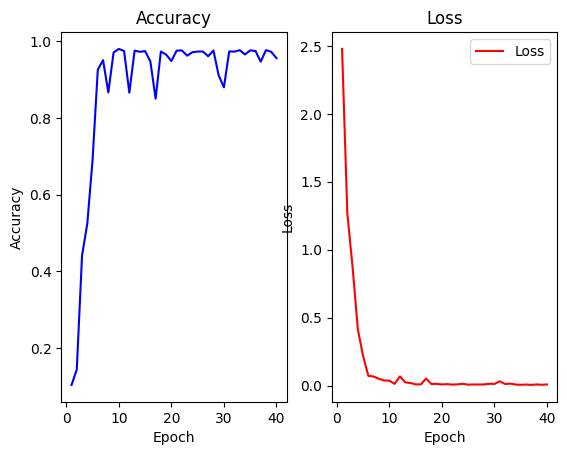

In [31]:
# subplot result
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCH+1), accuracy_list, 'b', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')

print(accuracy_list)
print(loss_list)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCH+1), loss_list, 'r', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# conclusion

              precision    recall  f1-score   support

      Apples       1.00      0.98      0.99      3905
   Buildings       0.86      1.00      0.93      2778
      Ground       0.82      0.95      0.88       374
       Woods       1.00      1.00      1.00      8969
    Vineyard       1.00      1.00      1.00     10317
       Roads       0.99      0.86      0.92      3052

    accuracy                           0.98     29395
   macro avg       0.94      0.96      0.95     29395
weighted avg       0.98      0.98      0.98     29395

OA =  98.0268753189318 
AA =  96.2418984224825 
Kappa =  97.35718650760991


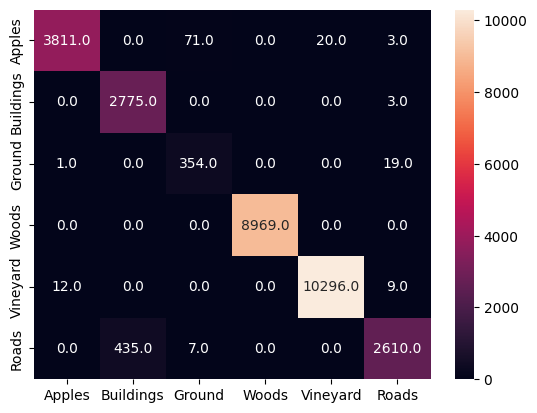

In [4]:
# load the saved parameters
model = MFT(FM, NC, NCLIDAR, Classes, HSIOnly).cuda()
# model.load_state_dict(torch.load(f"{weight_folder_path + datasetName}/net_params_{FileName}_{20}.pkl"))       #20 EPOCH ile kiyaslanabilir
model.load_state_dict(torch.load(f"{weight_folder_path + datasetName}/net_params_{FileName}_{EPOCH}_axial.pkl"))

model.eval()
KAPPA = []
OA = []
AA = []
ELEMENT_ACC = np.zeros((3, Classes))

confusion, oa, each_acc, aa, kappa, target_names = reports(TestPatch1,TestPatch2,TestLabel1,datasetName,model)
sns.heatmap(confusion, annot=True, fmt='.1f', xticklabels=target_names, yticklabels=target_names)
KAPPA.append(kappa)
OA.append(oa)
AA.append(aa)
ELEMENT_ACC[0, :] = each_acc
print("OA = ", oa, "\nAA = ", aa, "\nKappa = ", kappa)
record.record_output(OA, AA, KAPPA, ELEMENT_ACC, weight_folder_path + datasetName +'/'+FileName+'_BandSize'+str(BandSize)+'_Report_' + datasetName +'_axial.txt')

# MFT WITH PIXEL TOKENIZATION

In [ ]:
#MFT WITH PIXEL TOKENIZATION

from torch.nn import LayerNorm,Linear,Dropout,Softmax
import copy



def INF(B,H,W):
     return -torch.diag(torch.tensor(float("inf")).cuda().repeat(H),0).unsqueeze(0).repeat(B*W,1,1)

     
class HetConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,padding = None, bias = None,p = 64, g = 64):
        super(HetConv, self).__init__()
        # Groupwise Convolution
        self.gwc = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,groups=g,padding = kernel_size//3, stride = stride)
        # Pointwise Convolution
        self.pwc = nn.Conv2d(in_channels, out_channels, kernel_size=1,groups=p, stride = stride)
    def forward(self, x):
        return self.gwc(x) + self.pwc(x)   
    
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.1, proj_drop=0.1):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.wq = nn.Linear(head_dim, dim , bias=qkv_bias)
        self.wk = nn.Linear(head_dim, dim , bias=qkv_bias)
        self.wv = nn.Linear(head_dim, dim , bias=qkv_bias)
#         self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim * num_heads, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):

        B, N, C = x.shape
        q = self.wq(x[:, 0:1, ...].reshape(B, 1, self.num_heads, C // self.num_heads)).permute(0, 2, 1, 3)  # B1C -> B1H(C/H) -> BH1(C/H)
        k = self.wk(x.reshape(B, N, self.num_heads, C // self.num_heads)).permute(0, 2, 1, 3)  # BNC -> BNH(C/H) -> BHN(C/H)
        v = self.wv(x.reshape(B, N, self.num_heads, C // self.num_heads)).permute(0, 2, 1, 3)  # BNC -> BNH(C/H) -> BHN(C/H)
        attn = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
#         attn = (q @ k.transpose(-2, -1)) * self.scale  # BH1(C/H) @ BH(C/H)N -> BH1N
        attn = attn.softmax(dim=-1)
#         attn = self.attn_drop(attn)
        x = torch.einsum('bhij,bhjd->bhid', attn, v).transpose(1, 2)
#         x = (attn @ v).transpose(1, 2)
        x = x.reshape(B, 1, C * self.num_heads)   # (BH1N @ BHN(C/H)) -> BH1(C/H) -> B1H(C/H) -> B1C
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
class Mlp(nn.Module):
    def __init__(self, dim):
        super(Mlp, self).__init__()
        self.fc1 = Linear(dim, 512)
        self.fc2 = Linear(512, dim)
        self.act_fn = nn.GELU()
        self.dropout = Dropout(0.1)

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x
class Block(nn.Module):
    def __init__(self, dim):
        super(Block, self).__init__()
        self.hidden_size = dim
        self.attention_norm = LayerNorm(dim, eps=1e-6)
        self.ffn_norm = LayerNorm(dim, eps=1e-6)
        self.ffn = Mlp(dim)
#         self.attn = Attention(dim = 64)
        self.attn = CrossAttention(dim = dim)
    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x= self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        
        return x

class CrossAttentionBlock(nn.Module):

    def __init__(self, dim, num_heads= 8, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0.1, attn_drop=0.1,
                 drop_path=0.1, act_layer=nn.GELU, norm_layer=nn.LayerNorm, has_mlp=False):
        super().__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(dim, eps=1e-6)
        for _ in range(2):
            layer = Block(dim)
            self.layer.append(copy.deepcopy(layer))
       

    def forward(self, x):
        for layer_block in self.layer:
            x= layer_block(x)
            
        encoded = self.encoder_norm(x)
       
        

        return encoded[:,0]


class CNN(nn.Module):
    def __init__(self, FM, NC, NCLidar, Classes, HSIOnly):
        super(CNN, self).__init__()
        self.HSIOnly = HSIOnly
        self.conv5 = nn.Sequential(
            nn.Conv3d(1, 8, (9, 3, 3), padding=(0,1,1), stride = 1),
            nn.BatchNorm3d(8),
            nn.ReLU()
        )
        
        self.conv6 = nn.Sequential(
            HetConv(8 * (NC - 8), FM*4,
                p = 1,
                g = (FM*4)//4 if (8 * (NC - 8))%FM == 0 else (FM*4)//8,
                   ),
            nn.BatchNorm2d(FM*4),
            nn.ReLU()
        )
        
        self.last_BandSize = NC//2//2//2
        
        self.lidarConv = nn.Sequential(
                        nn.Conv2d(NCLidar,1,3,1,1),
                        nn.BatchNorm2d(1),
                        nn.GELU()
                        )
        self.ca = CrossAttentionBlock(FM*4)
        self.out3 = nn.Linear(FM*4 , Classes)
        self.position_embeddings = nn.Parameter(torch.randn(1, 4 + 1, FM*4))
        self.dropout = nn.Dropout(0.1)
        torch.nn.init.xavier_uniform_(self.out3.weight)
        torch.nn.init.normal_(self.out3.bias, std=1e-6)
        self.token_wA = nn.Parameter(torch.empty(1, 4, 64),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wA)
        self.token_wV = nn.Parameter(torch.empty(1, 64, 64),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wV)
        
        self.token_wA_L = nn.Parameter(torch.empty(1, 1, 1),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wA_L)
        self.token_wV_L = nn.Parameter(torch.empty(1, 1, 64),
                                     requires_grad=True)  # Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wV_L)
                
        

    def forward(self, x1, x2):
        x1 = x1.reshape(x1.shape[0],-1,patchsize,patchsize)
        x1 = x1.unsqueeze(1)
        x2 = x2.reshape(x2.shape[0],-1,patchsize,patchsize)
        x1 = self.conv5(x1)
        x1 = x1.reshape(x1.shape[0],-1,patchsize,patchsize)
        
        x1 = self.conv6(x1)
        x2 = self.lidarConv(x2)
        x2 = x2.reshape(x2.shape[0],-1,patchsize**2)
        x2 = x2.transpose(-1, -2)
        wa_L = self.token_wA_L.expand(x1.shape[0],-1,-1)
        A_L = torch.einsum('bij,bjk->bik', x2, wa_L)
        A_L = rearrange(A_L, 'b h w -> b w h')  # Transpose
        A_L = A_L.softmax(dim=-1)
        wv_L = self.token_wV_L.expand(x2.shape[0],-1,-1)
        VV_L = torch.einsum('bij,bjk->bik', x2, wv_L)
        x2 = torch.einsum('bij,bjk->bik', A_L, VV_L)
        x1 = x1.flatten(2)
        
        x1 = x1.transpose(-1, -2)
        wa = self.token_wA.expand(x1.shape[0],-1,-1)
        wa = rearrange(wa, 'b h w -> b w h')  # Transpose
        A = torch.einsum('bij,bjk->bik', x1, wa)
        A = rearrange(A, 'b h w -> b w h')  # Transpose
        A = A.softmax(dim=-1)
        wv = self.token_wV.expand(x1.shape[0],-1,-1)
        VV = torch.einsum('bij,bjk->bik', x1, wv)
        T = torch.einsum('bij,bjk->bik', A, VV)
        x = torch.cat((x2, T), dim = 1) #[b,n+1,dim]
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        x = self.ca(x)
        x = x.reshape(x.shape[0],-1)
        out3 = self.out3(x)
        return out3
  


# batchsize = 64
# patchsize = 11
# model = MFT(16, 144, 1, 15, False).to("cuda")
# summary(model, [(144,121),(1,121)],device = 'cuda')